In [20]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
img = cv2.imread('spot.png', cv2.IMREAD_GRAYSCALE) # считываем картинку

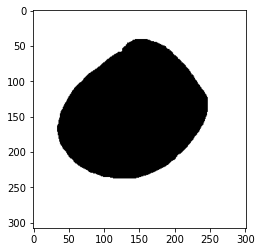

In [3]:
plt.imshow(img, cmap='gray')

In [4]:
print("Высота:"+str(img.shape[0]))
print("Ширина:" + str(img.shape[1]))
a = img.shape[0]
b = img.shape[1]
c = int(math.sqrt(a**2 + b**2))

Высота:308
Ширина:301


Центральные направления

In [5]:
center_line = int(img.shape[0]) // 2 # центральная строка
center_column = int(img.shape[1]) // 2 # центральный столбец

### Эксперимент с горизонтальным направлением
Рассмотрим отдельно центральную строку изображения. Выведем ее значения, затем вычислим градиент и убедимся на графиках, что рисутствуют 2 пика.

In [6]:
s = np.array(list(map(int, img[center_line]))) 
print(s)

[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 255 255 255 25

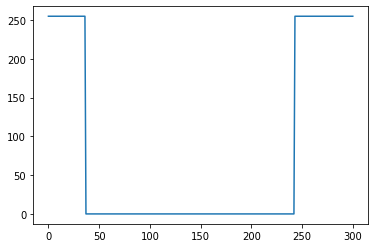

In [7]:
x = np.arange(img.shape[1]) # размер строки
y = s
plt.figure()
plt.plot(x, y)
plt.show()

Строим градиент и видим 2 пика

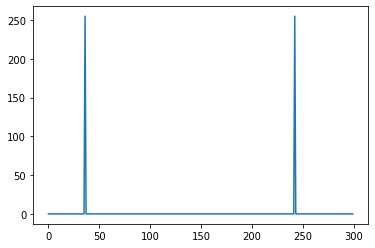

In [8]:
grad = np.zeros(img.shape[1] - 1)
for i in range(img.shape[1] - 1):
    grad[i] = abs(y[i+1] - y[i])
plt.figure()
plt.plot(x[:img.shape[1] - 1], grad)
plt.show()

### Общий случай
Сначала задаем кол-во направлений, затем вычисляем по ним градиенты яркости как в предыдущем примере и отмечаем точки пиков на изображении. Потом соединяем полученные точки и имеем примерные границы пятна.

Функция, которая возвращает массив значений яркости и координаты по заданному углом направлению

In [9]:
def get_brightness(alpha):  
    # массив для яркости
    res = np.zeros(c)
    res.fill(255)
    # массив для координат
    coordinates = np.zeros((2, c))
    # координаты известной точки
    x_0 = center_line
    y_0 = center_column
    # направление
    a_x = - math.sin(alpha)
    a_y = math.cos(alpha)
    # случай горизонтального направления
    if alpha == 0:
        res = img[x_0]
        coordinates[0] = x_0
        coordinates[1] = np.arange(c)
        return res, coordinates
    # поиск пределов t
    if alpha > math.pi / 2:
        t_1 = math.ceil(max((a - x_0) / a_x, (b - y_0) / a_y)) 
        t_2 = math.floor(min(- x_0 / a_x, - y_0 / a_y)) 
    else:
        t_1 = math.ceil(max((a - x_0) / a_x, - y_0 / a_y)) 
        t_2 = math.floor(min(- x_0 / a_x, (b - y_0) / a_y)) 
    # проход по изображению
    i = 0
    for t in range(t_1 + 1, t_2 - 1):
        x = int(x_0 + a_x * t)
        y = int(y_0 + a_y * t)
        coordinates[0, i] = x
        coordinates[1, i] = y
        i += 1
        res[i] = img[x, y]
        
    return res, coordinates

100


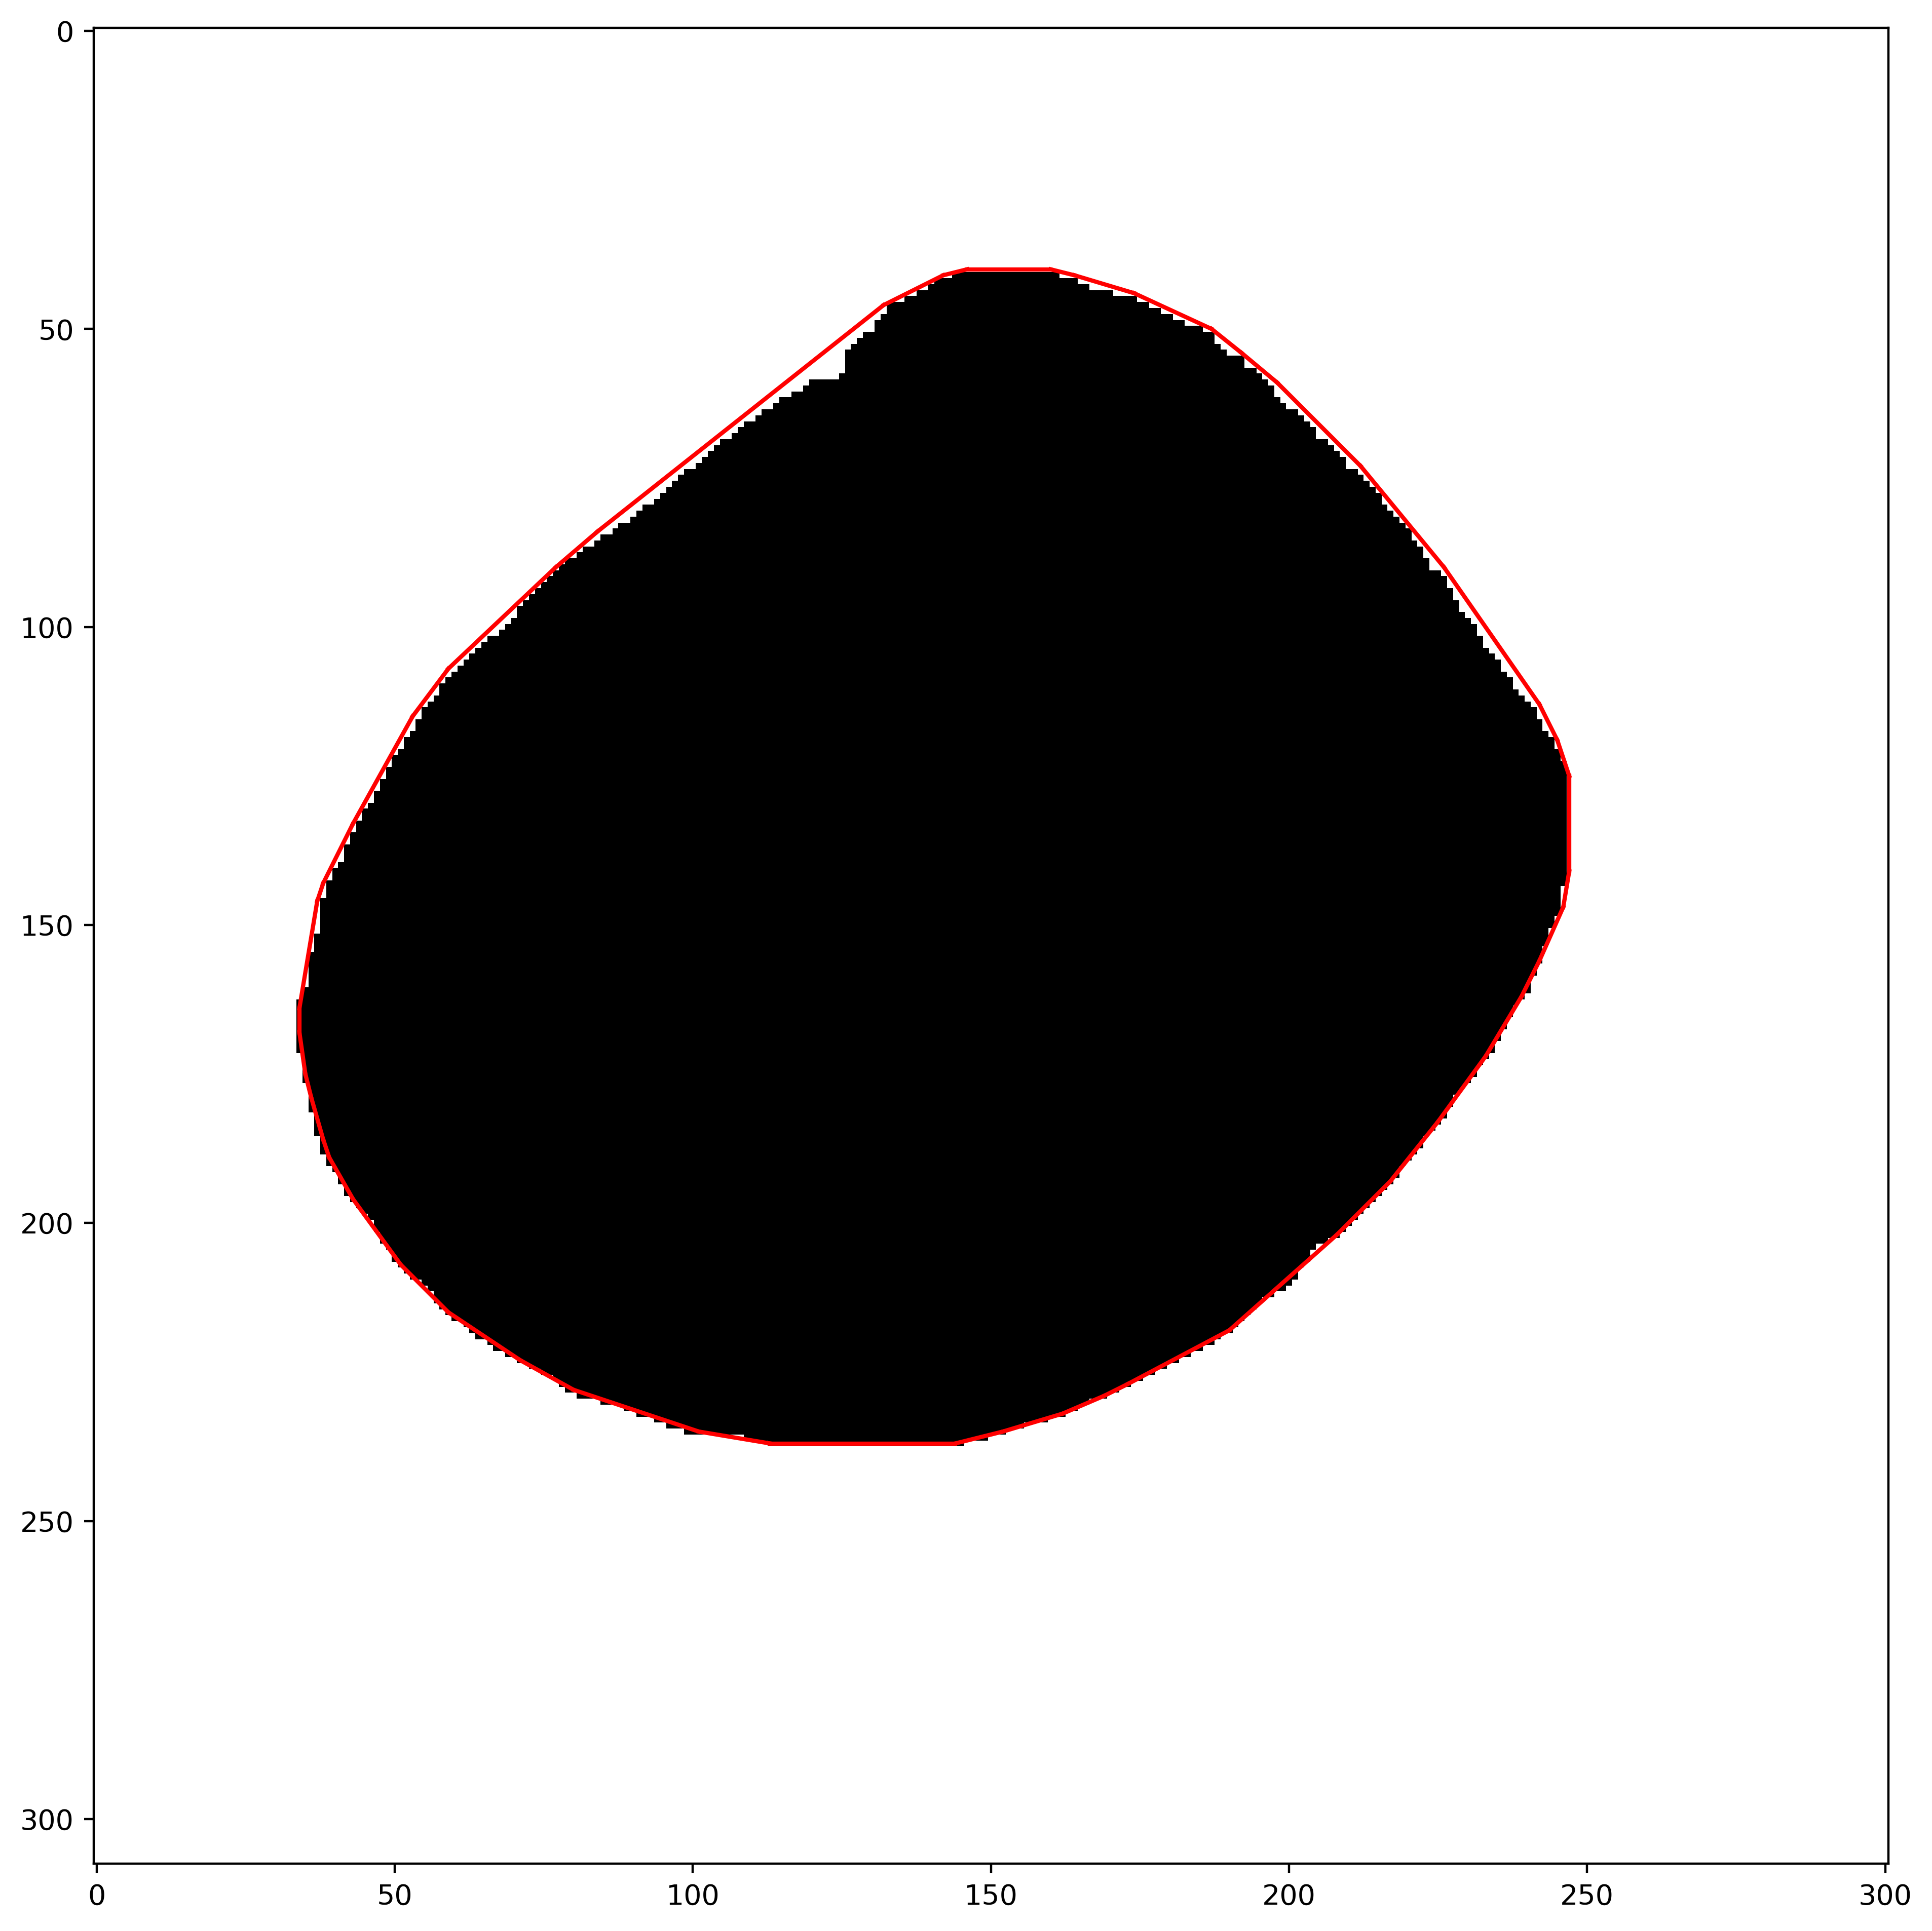

In [30]:
res = cv2.imread('spot.png', cv2.IMREAD_COLOR) # здесь будет сегментрованное изображение

n = int(input()) # кол-во прямых-направлений
points = np.zeros((n * 2, 2)) # массив для координат точек, которые мы будем соединять

for i in range(n):
    alpha = i * math.pi / n # угол направления с горизонталью
    bright, coordinates = get_brightness(alpha)
    
    size = bright.size
    grad = np.zeros(size - 1)
    for j in range(size - 1):
        grad[j] = abs(int(bright[j+1]) - int(bright[j]))
        
    # идем с начала массива и находим максимум
    first = 0
    max_grad = 0
    for j in range(size // 2):
        if grad[j] > max_grad:
            max_grad = grad[j]
            first = j
    # идем с конца массиваи
    last = img.shape[1] - 2
    max_grad = 0
    for j in range(size - 2, size // 2, -1):
         if grad[j] > max_grad:
                max_grad = grad[j]
                last = j
                
    # рисуем разметку
    #res[int(coordinates[0, first]), int(coordinates[1, first])] = (255, 0, 0)
    #res[int(coordinates[0, last]), int(coordinates[1, last])] = (255, 0, 0)
    # i-я точка
    points[i, 1] = int(coordinates[0, first])
    points[i, 0] = int(coordinates[1, first])
    # n+i-я точка
    points[n + i, 1] = int(coordinates[0, last])
    points[n + i, 0] = int(coordinates[1, last])
    
'''for i in range(1,2 * n):
    lineThickness = 1
    points = points.astype(np.int32)
    x1 = points[0, i - 1]
    y1 = points[1, i - 1]
    x2 = points[0, i]
    y2 = points[1, i]
    cv2.line(res, (x1, y1), (x2, y2), (255,0,0), lineThickness)
cv2.line(res, (x1, y1), (x2, y2), (255,0,0), lineThickness) '''

hull = ConvexHull(points)
plt.figure(figsize=(18, 12), dpi=400)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r')
    
plt.imshow(res)

### Теперь попробуем сделать то же самое, но с применением Sobel фильтра

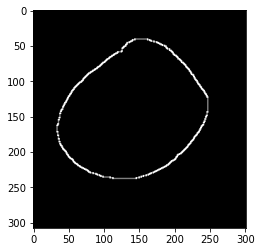

In [47]:
scale = 1
delta = 0
ddepth = cv2.CV_16S
gray = cv2.imread('spot.png', cv2.IMREAD_GRAYSCALE) # считываем картинку
grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
plt.figure()
plt.imshow(grad, cmap = 'gray')